# Xopt Parallel Examples

Xopt provides methods to parallelize optimizations using Processes, Threads, MPI, and Dask using the `concurrent.futures` interface as defined in  https://www.python.org/dev/peps/pep-3148/ .

In [1]:
from xopt import Xopt

In [2]:
# Helpers for this notebook
import multiprocessing
N_CPUS=multiprocessing.cpu_count()
N_CPUS

import os

# directory for data. 
os.makedirs("temp", exist_ok=True)

# Notebook printing output
#from xopt import output_notebook
#output_notebook()

# Nicer plotting
%config InlineBackend.figure_format = 'retina'


The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
# Make a proper input file.
YAML = """
xopt:
  asynch: True
  max_evaluations: 1000

generator:
  name: cnsga
  output_path: temp
  population_size:  64
  
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    sleep: 0
    random_sleep: 0.1
  
vocs:
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  linked_variables: {x9: x1}
  constants: {a: dummy_constant}

"""
X = Xopt(YAML)
X


            Xopt
________________________________
Version: 1.1.2+31.g422c5a9.dirty
Data size: 0
Config as YAML:
xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0.1, raise_probability: 0}
  vectorized: false
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constants: {a: dummy_constant}
  linked_variables: {x9: x1}


In [4]:
%%timeit
# Check that the average time is close to random_sleep
X.evaluator.function({"x1": 0.5, "x2": 0.5}, random_sleep = .1)

96.5 ms ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%time
X.run()

CPU times: user 6.94 s, sys: 225 ms, total: 7.16 s
Wall time: 1min 50s


# Processes

In [6]:
from concurrent.futures import ProcessPoolExecutor

In [7]:
%%time
X = Xopt(YAML)

with ProcessPoolExecutor() as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    X.run()
len(X.data)

CPU times: user 3.86 s, sys: 294 ms, total: 4.15 s
Wall time: 12.9 s


1000

# Threads

Continue running, this time with threads.

In [8]:
from concurrent.futures import ThreadPoolExecutor

In [9]:
%%time

X = Xopt(YAML)

with ThreadPoolExecutor() as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    X.run()
len(X.data)

CPU times: user 4.3 s, sys: 192 ms, total: 4.49 s
Wall time: 11.3 s


1000

# MPI 

The `test.yaml` file completely defines the problem. We will also direct the logging to an `xopt.log` file. The following invocation recruits 4 MPI workers to solve this problem.

We can also continue by calling `.save` with a JSON filename. This will write all of previous results into the file.

In [10]:
X = Xopt(YAML)
X.yaml('test.yaml') # Write this input to file
!cat test.yaml

xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0.1, raise_probability: 0}
  vectorized: false
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constants: {a: dummy_constant}
  linked_variables: {x9: x1}


In [11]:
%%time
!mpirun -n {N_CPUS} python -m mpi4py.futures -m xopt.mpi.run -vv --logfile xopt.log test.yaml

Namespace(input_file='test.yaml', logfile='xopt.log', verbose=2)
Parallel execution with 10 workers
Initializing Xopt object
Initializing generator cnsga,
Created toolbox with 2 variables, 2 constraints, and 2 objectives.
    Using selection algorithm: nsga2
Initializing Xopt object
Xopt object initialized
Enabling async mode

            Xopt
________________________________
Version: 1.1.2+31.g422c5a9.dirty
Data size: 0
Config as YAML:
xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0.1, raise_probability: 0}
  vectorized: false
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE

In [12]:
!tail xopt.log

2022-08-18T11:45:27-0700 - xopt.base - INFO - Running Xopt step
2022-08-18T11:45:27-0700 - xopt.base - INFO - Running Xopt step
2022-08-18T11:45:27-0700 - xopt.base - INFO - Running Xopt step
2022-08-18T11:45:27-0700 - xopt.base - INFO - Running Xopt step
2022-08-18T11:45:27-0700 - xopt.base - INFO - Running Xopt step
2022-08-18T11:45:27-0700 - xopt.base - INFO - Running Xopt step
2022-08-18T11:45:27-0700 - xopt.base - INFO - Running Xopt step
2022-08-18T11:45:27-0700 - xopt.base - INFO - Running Xopt step
2022-08-18T11:45:27-0700 - xopt.base - INFO - Running Xopt step
2022-08-18T11:45:27-0700 - xopt.base - INFO - Xopt is done. Max evaluations 1000 reached.


# Dask



In [13]:
from dask.distributed import Client
client = Client()
executor = client.get_executor()
client

2022-08-18 11:45:28,982 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/dask-worker-space/worker-o2x19bac', purging
2022-08-18 11:45:28,982 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/dask-worker-space/worker-pkfm2l0b', purging
2022-08-18 11:45:28,982 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/dask-worker-space/worker-2pe9ydgc', purging
2022-08-18 11:45:28,982 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/dask-worker-space/worker-3ol1dgla', purging
2022-08-18 11:45:28,982 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/dask-worker-space/worker-37kim0g2', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54856,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:54896,Total threads: 2
Dashboard: http://127.0.0.1:54897/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:54861,


In [14]:
%%time
X = Xopt(YAML)
X.evaluator.executor = executor
X.evaluator.max_workers = N_CPUS
X.run()
len(X.data)

CPU times: user 4.25 s, sys: 559 ms, total: 4.81 s
Wall time: 12.5 s


1000

# Load output into Pandas

This algorithm writes two types of files: `gen_{i}.json` with all of the new individuals evaluated in a generation, and `pop_{i}.json` with the latest best population. Xopt provides some functions to load these easily into a Pandas dataframe for further analysis.

In [15]:
import pandas as pd

In [16]:
X.data

,x1,x2,a,x9,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error
10,2.471422,0.488736,dummy_constant,2.471422,2.471422,0.488736,5.446776,3.886633,"[1, 2, 3]",0.011140,False
6,0.976978,2.405552,dummy_constant,0.976978,0.976978,2.405552,5.641776,3.858635,"[1, 2, 3]",0.038039,False
7,0.455740,2.939118,dummy_constant,0.455740,0.455740,2.939118,7.923855,5.951254,"[1, 2, 3]",0.074599,False
11,0.232046,0.367798,dummy_constant,0.232046,0.232046,0.367798,-0.719546,0.089277,"[1, 2, 3]",0.036718,False
8,1.494465,2.718696,dummy_constant,1.494465,1.494465,2.718696,8.643407,5.911574,"[1, 2, 3]",0.058163,False
...,...,...,...,...,...,...,...,...,...,...,...
998,0.801200,0.637918,dummy_constant,NaN,0.801200,0.637918,0.072322,0.109743,"[1, 2, 3]",0.037957,False
1006,0.480176,0.997499,dummy_constant,NaN,0.480176,0.997499,0.163026,0.247899,"[1, 2, 3]",0.008176,False
989,1.272588,0.147963,dummy_constant,NaN,1.272588,0.147963,0.669124,0.720823,"[1, 2, 3]",0.191139,False
1002,0.583817,0.787997,dummy_constant,NaN,0.583817,0.787997,0.033047,0.089968,"[1, 2, 3]",0.071444,False


In [17]:
df = pd.concat([X.data, X.vocs.feasibility_data(X.data)], axis=1)
df[df['feasible']]

,x1,x2,a,x9,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error,feasible_c1,feasible_c2,feasible
9,0.547623,1.169586,dummy_constant,0.547623,0.547623,1.169586,0.592854,0.450613,"[1, 2, 3]",0.110823,False,True,True,True
26,0.980003,0.426040,dummy_constant,0.980003,0.980003,0.426040,0.045761,0.235873,"[1, 2, 3]",0.081441,False,True,True,True
18,0.922711,0.491246,dummy_constant,0.922711,0.922711,0.491246,0.090082,0.178761,"[1, 2, 3]",0.171685,False,True,True,True
66,0.432459,1.093330,dummy_constant,0.432459,0.432459,1.093330,0.285668,0.356603,"[1, 2, 3]",0.087319,False,True,True,True
72,0.504830,1.092646,dummy_constant,0.504830,0.504830,1.092646,0.368625,0.351253,"[1, 2, 3]",0.009447,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,1.048656,0.099549,dummy_constant,NaN,1.048656,0.099549,0.103946,0.461385,"[1, 2, 3]",0.014905,False,True,True,True
998,0.801200,0.637918,dummy_constant,NaN,0.801200,0.637918,0.072322,0.109743,"[1, 2, 3]",0.037957,False,True,True,True
1006,0.480176,0.997499,dummy_constant,NaN,0.480176,0.997499,0.163026,0.247899,"[1, 2, 3]",0.008176,False,True,True,True
1002,0.583817,0.787997,dummy_constant,NaN,0.583817,0.787997,0.033047,0.089968,"[1, 2, 3]",0.071444,False,True,True,True


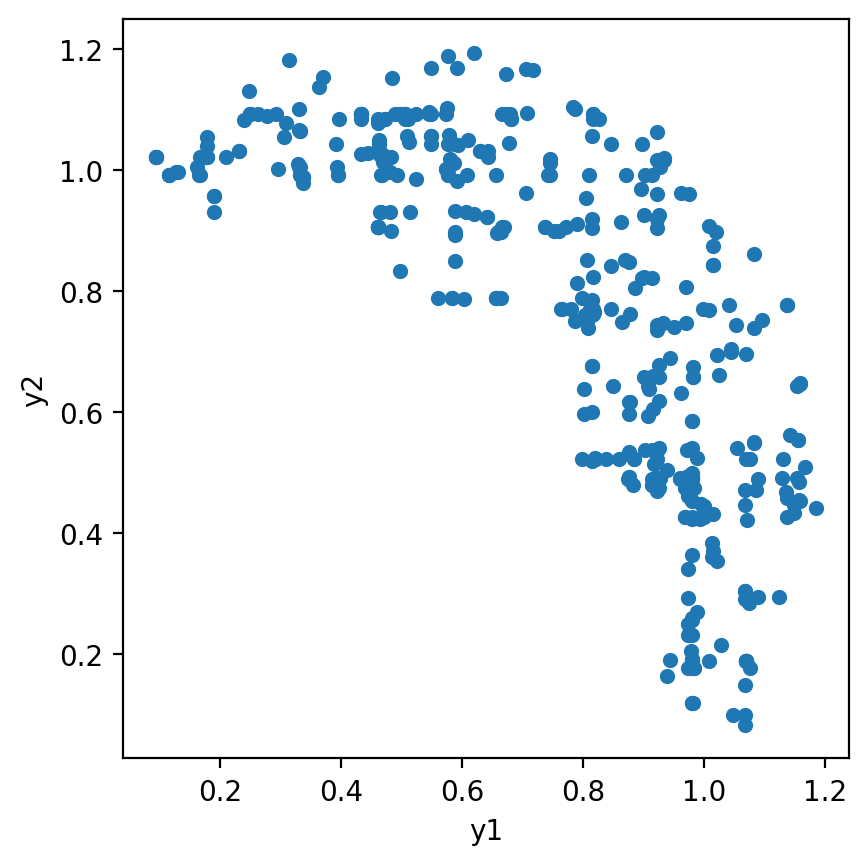

In [18]:
# Plot the feasible ones
feasible_df = df[df["feasible"]]
feasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

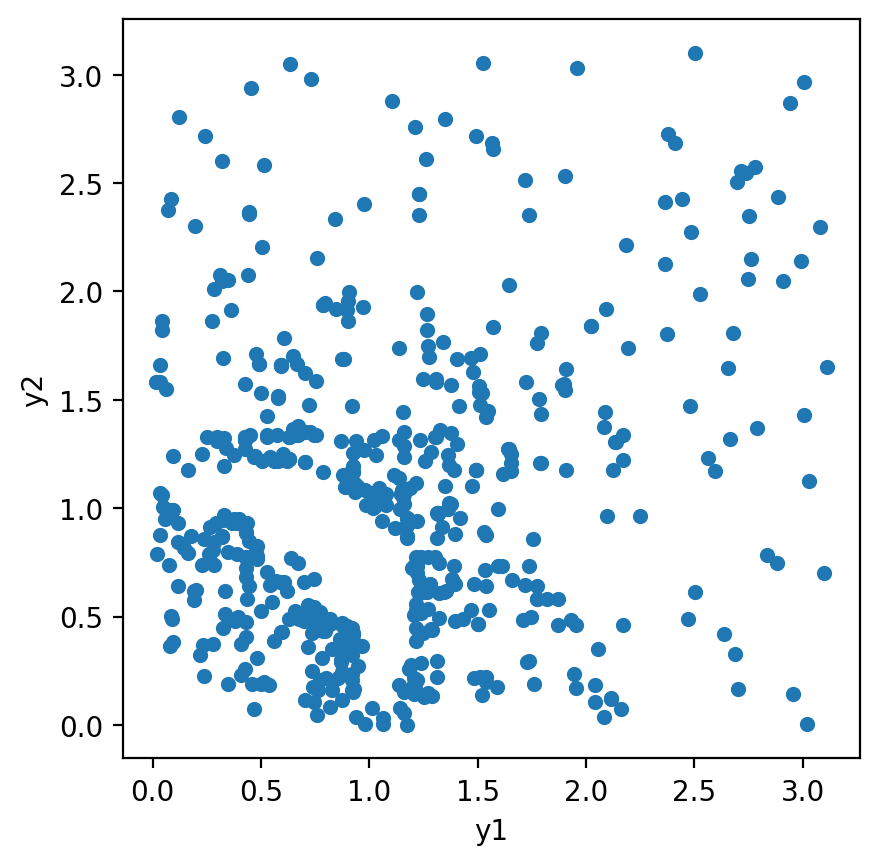

In [19]:
# Plot the infeasible ones
infeasible_df = df[~df["feasible"]]
infeasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

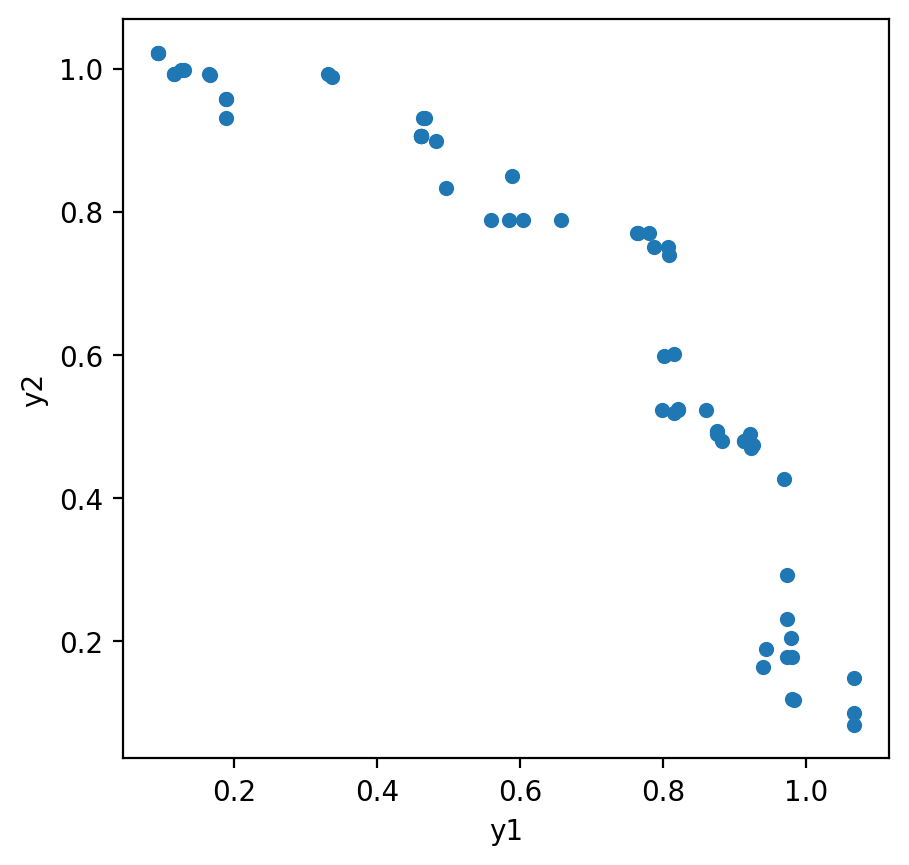

In [20]:
# This is the final population
df1 = X.generator.population
df1.plot("y1", "y2", kind="scatter").set_aspect("equal")

# matplotlib plotting

You can always use matplotlib for customizable plotting

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

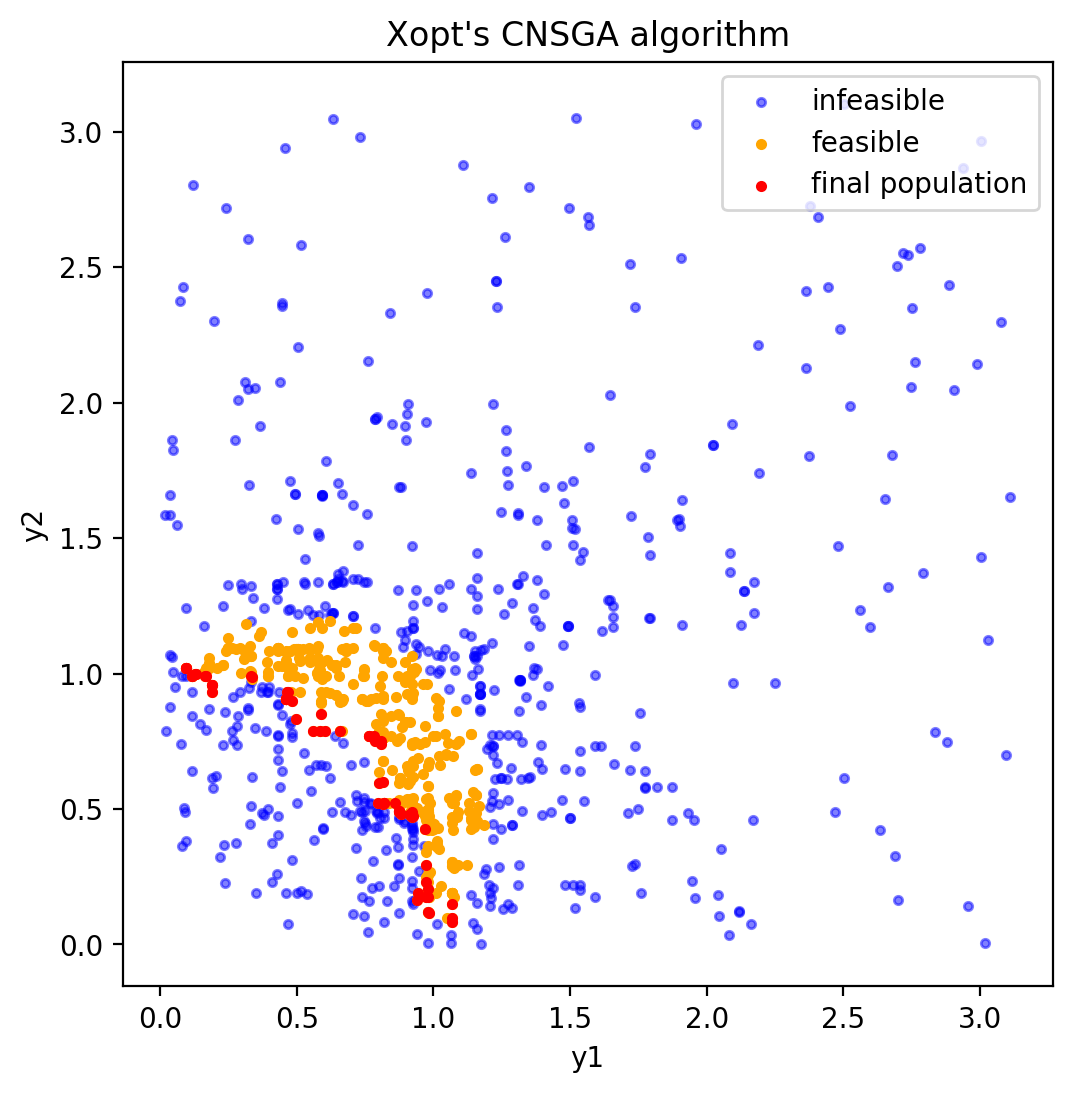

In [22]:
# Extract objectives from output
k1, k2 = "y1", "y2"

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    infeasible_df[k1],
    infeasible_df[k2],
    color="blue",
    marker=".",
    alpha=0.5,
    label="infeasible",
)
ax.scatter(
    feasible_df[k1], feasible_df[k2], color="orange", marker=".", label="feasible"
)
ax.scatter(df1[k1], df1[k2], color="red", marker=".", label="final population")
ax.set_xlabel(k1)
ax.set_ylabel(k2)
ax.set_aspect("auto")
ax.set_title(f"Xopt's CNSGA algorithm")
plt.legend()

In [23]:
# Cleanup
!rm -r dask-worker-space
!rm -r temp
!rm xopt.log*
!rm test.yaml

rm: dask-worker-space: No such file or directory
